In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import sc2ts
import tszip

import nb_utils
from nb_utils import DATA_DIR

png_dir = Path("../figures/static")

recomb_df = pd.read_csv(DATA_DIR / "recombinants.csv").set_index("sample_id")

In [2]:
df_robust = recomb_df[recomb_df.net_min_supporting_loci_lft_rgt_ge_4].copy()
print(f"Using {len(df_robust)} robust recombinants")

Using 354 robust recombinants


In [3]:
ts = tszip.load(DATA_DIR / "sc2ts_viridian_v1.2.trees.tsz")
re_labels = nb_utils.standard_recombinant_labels(ts, DATA_DIR / "pango_x_events.csv")

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


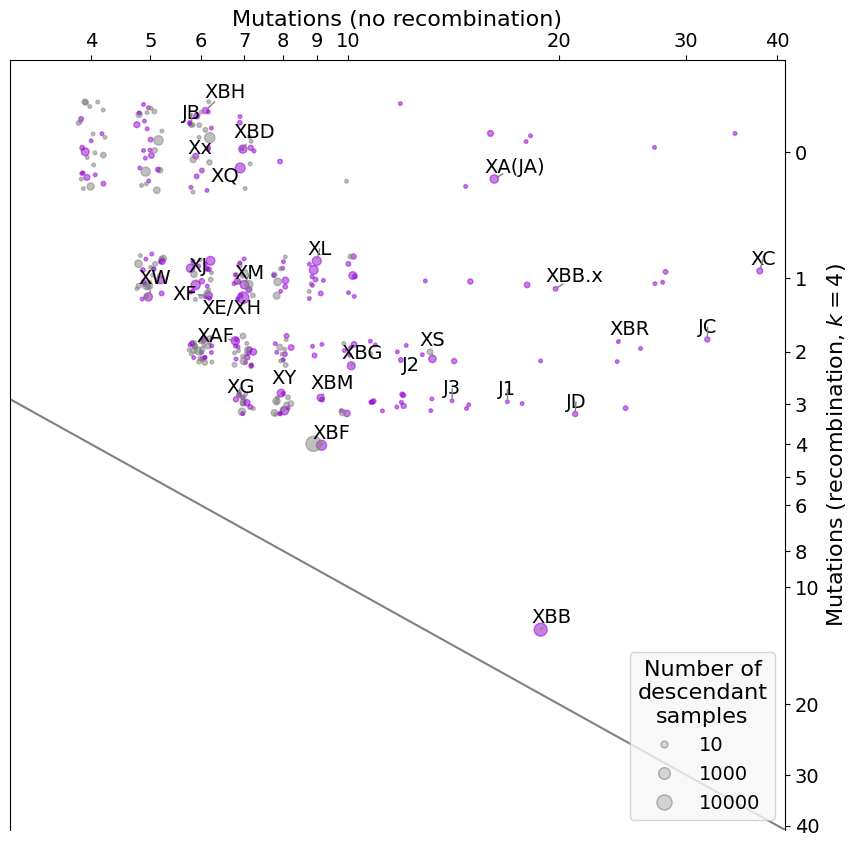

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import adjustText

def draw_averted_scatterplot(df, ax, jitter_seed=2, jitter_width=0.25, legend_loc="lower right"):
    def pointscale(num_descendant_samples):
        return 10 * (np.log(num_descendant_samples + 1))

    np.random.seed(jitter_seed)
    j1 = np.random.uniform(-jitter_width, jitter_width, len(df))
    j2 = np.random.uniform(-jitter_width, jitter_width, len(df))

    colorpal = ["gray", "darkviolet"]
    patches = [
        mpatches.Patch(color=colorpal[0], label="Non-recombinant"),
        mpatches.Patch(color=colorpal[1], label="Recombinant"),
    ]

    x = df.k1000_muts
    y = df.num_mutations  # for k == 4
        
    ax.scatter(
        (1 + x) + j1,
        (1 + y) + j2,
        alpha=0.5,
        s=pointscale(df.num_descendant_samples),
        c=[colorpal[int(x)] for x in df.is_rebar_recombinant],
        edgecolors=None,
    )
    ax.set_xlabel("Mutations (no recombination)", fontsize=16)
    ax.set_ylabel("Mutations (recombination, $k=4$)", fontsize=16)

    legend_elements = [
        Line2D([0], [0], marker='o', color='none', markerfacecolor='lightgrey', markeredgecolor="darkgrey",
               markersize=np.sqrt(pointscale(10)), label='10'),
        Line2D([0], [0], marker='o', color='none', markerfacecolor='lightgrey', markeredgecolor="darkgrey",
               markersize=np.sqrt(pointscale(1000)), label='1000'),
        Line2D([0], [0], marker='o', color='none', markerfacecolor='lightgrey', markeredgecolor="darkgrey",
               markersize=np.sqrt(pointscale(100000)), label='10000')
    ]

    leg = ax.legend(
        handles=legend_elements,
        title="Number of\ndescendant\nsamples",
        fontsize=14,
        title_fontsize=16,
        loc=legend_loc,
        frameon=True,
        facecolor='0.97',
    )
    leg.get_title().set_multialignment('center')

    texts = []
    for i, (xx, yy, row) in enumerate(zip(x, y, df.itertuples())):
        label = re_labels.get(row.recombinant)
        if label is not None:
            texts.append(ax.text((1 + xx) + j1[i], (1 + yy) + j2[i], label, fontsize=14, ha="right"))

    ax.plot([0.1, 10, 100], [0.1, 10, 100], c="gray")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(3.9, 42)
    ax.set_ylim(0.6, 42)
    #ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.xaxis.set_label_position('top')
    ax.yaxis.set_label_position('right')
    ax.invert_yaxis()
    ax.minorticks_off()
    xticks = [5, 6, 7, 8, 9, 10, 11, 21, 31, 41]
    yticks = [1, 2, 3, 4, 5, 6, 7, 9, 11, 21, 31, 41]
    ax.set_xticks(ticks = xticks, labels = [t - 1 for t in xticks], fontsize=14)
    ax.set_yticks(ticks = yticks, labels = [t - 1 for t in yticks], fontsize=14)
    ax.tick_params(
        axis='x',   # Apply changes to the x-axis
        top=True, # Show ticks on the top side
        labeltop=True,    # Show tick labels on the top side
        bottom=False, # Hide ticks on the bottom side
        labelbottom=False,    # Hide tick labels on the bottom side
    )
    ax.tick_params(
        axis='y',   # Apply changes to the y-axis
        right=True, # Show ticks on the right side
        labelright=True,    # Show tick labels on the right side
        left=False, # Hide ticks on the left side
        labelleft=False,    # Hide tick labels on the left side
    )

    adjustText.adjust_text(
        texts,
        arrowprops=dict(
            relpos=(0.5, 0.0),
            arrowstyle="-",
            color="gray",
            shrinkA=10,
            lw=1,
        ),
        ax=ax,
    )

# Check it looks OK
_, ax = plt.subplots(1, 1, figsize=(10, 10))
draw_averted_scatterplot(df_robust, ax);

In [5]:
from PIL import Image

# Define RE nodes for which to show a copying pattern
copying_images = {"XA(JA)": {}, "XBB": {}, "XBB.x": {}, "XW": {}}

# This loop takes a little time to do the HTML copying pattern table -> PNG conversion
try:
    for label, val in copying_images.items():
        label = label.replace("XW", "XW")
        label = label.replace("XBB.x", "XBB.1")
        label = label.replace("XA(JA)", "XA")
        val['img'] = np.asarray(Image.open(png_dir / (label + ".png")))
except FileNotFoundError:
    print("You need to run the src/save_pangoX_copying_patterns.py script to generate copying patterns")
    raise

In [6]:
def draw_copying_patterns(copying_images, ax, y_scale):
    row_pos = [0.3, -0.1, -0.4]
    copying_images["XA(JA)"]["pos"] = [0, row_pos[0]]
    copying_images["XW"]["pos"] = [0, row_pos[1]]
    copying_images["XBB"]["pos"] = [0, row_pos[2]]   # Manually adjusted
    copying_images["XBB.x"]["pos"] = [0.40, row_pos[2]]

    ax.axis("off")
    for label, val in copying_images.items():
        img = val["img"]
        img_height, img_width = img.shape[:2]  # Get height and width
        aspect_ratio = img_width / img_height
        box = val["pos"] + [y_scale * aspect_ratio, 1]
        ax_image = ax.inset_axes(box)
        ax_image.imshow(val["img"], aspect="equal")
        ax_image.axis('off')  # Remove axis of the image
        ax_image.text(-6, 30, label, fontsize=15, ha="right")


In [7]:
df_robust['num_mutations_averted'] = df_robust.k1000_muts - df_robust.num_mutations
df_robust['tmrca'] = df_robust.parent_mrca_time - df_robust.recombinant_time  # ts.nodes_time[df_robust.parent_mrca] - ts.nodes_time[df_robust.recombinant]
    
rebar_nr_averted_muts = df_robust[~df_robust.is_rebar_recombinant].num_mutations_averted
rebar_re_averted_muts = df_robust[df_robust.is_rebar_recombinant].num_mutations_averted

rebar_nr_tmrca = df_robust[~df_robust.is_rebar_recombinant].tmrca
rebar_re_tmrca = df_robust[df_robust.is_rebar_recombinant].tmrca

rebar_nr_pango_dist = df_robust[~df_robust.is_rebar_recombinant].parent_pangonet_distance
rebar_re_pango_dist = df_robust[df_robust.is_rebar_recombinant].parent_pangonet_distance

In [8]:
def draw_stacked_histogram(
    ax,
    a,
    b,
    *,
    alegend,
    blegend,
    acolor,
    bcolor,
    xlabel,
    ylabel,
    xlim,
    bin_size,
    bar_width=0.8,
    show_legend=True,
    show_top_spline=True,
    show_right_spline=True,
    legend_loc=None,
):
    bin_edges = np.arange(xlim[0], xlim[1], bin_size)
    hist_a, _ = np.histogram(a, bins=bin_edges)
    hist_b, _ = np.histogram(b, bins=bin_edges)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2 - 0.5
    _ = ax.bar(
        bin_centers,
        hist_a,
        width=bar_width,
        label=alegend,
        color=acolor,
    )
    _ = ax.bar(
        bin_centers,
        hist_b,
        bottom=hist_a,
        width=bar_width,
        label=blegend,
        color=bcolor,
    )
    ax.set_xticks(bin_centers.astype(int))
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    if not show_top_spline:
        ax.spines['top'].set_visible(False)
    if not show_right_spline:
        ax.spines['right'].set_visible(False)
    if show_legend:
        ax.legend(
            fontsize=14,
            loc=legend_loc,
            title_fontsize=16,
            title="Rebar classification",
            frameon=True,
            facecolor='0.97',
        )


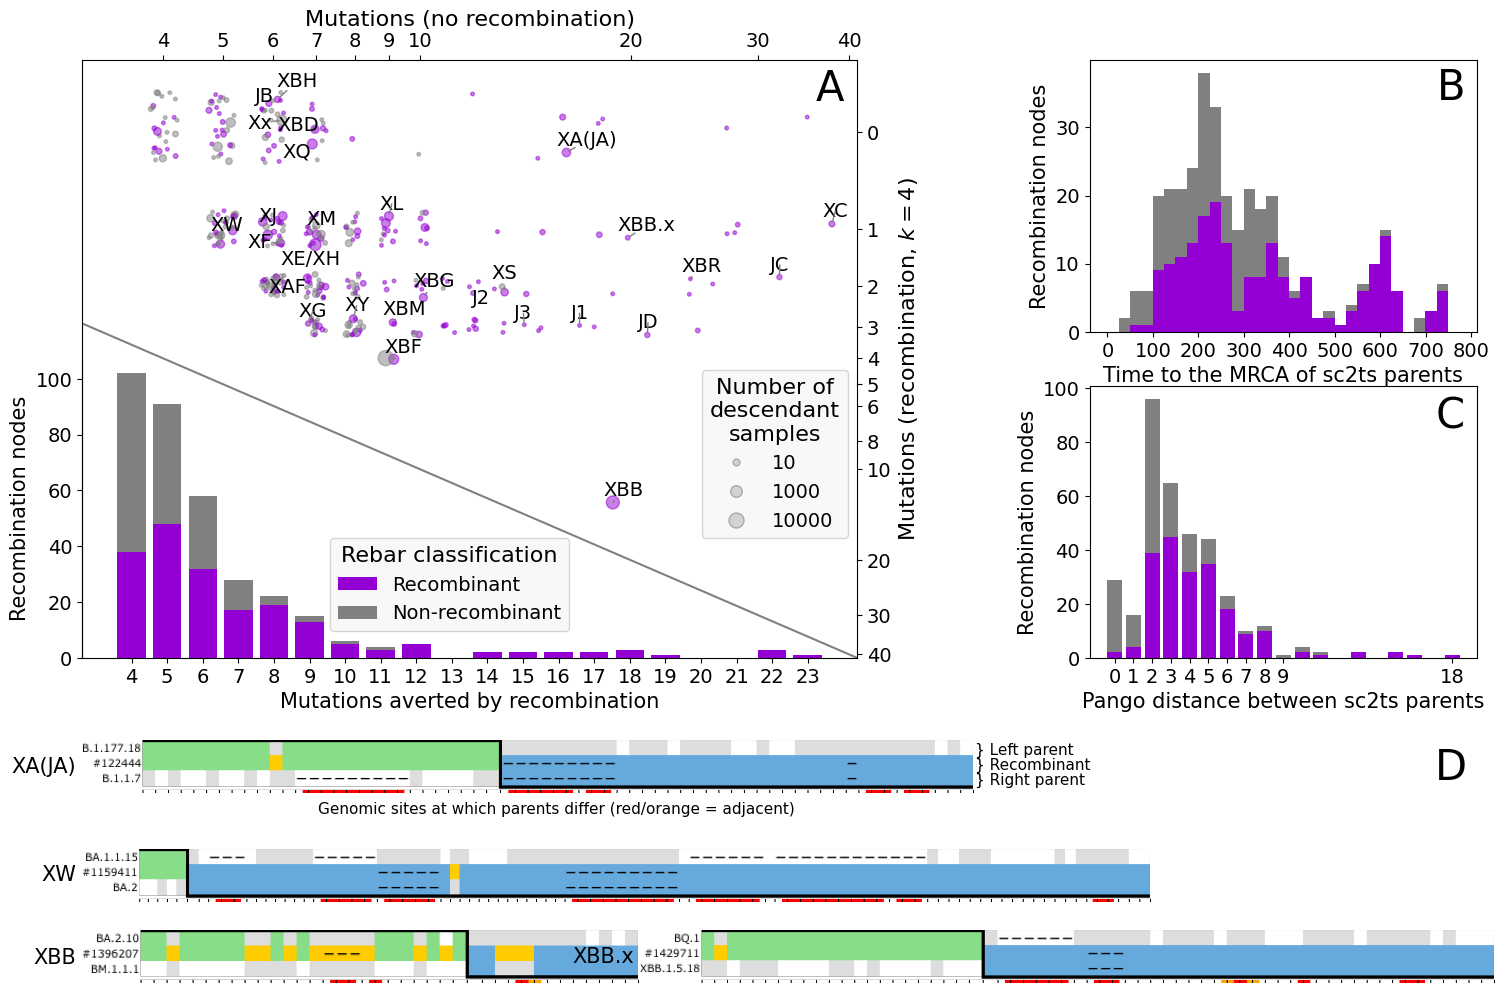

In [9]:
from matplotlib.gridspec import GridSpec

colorpal = ["gray", "darkviolet"]

fig = plt.figure(figsize=(18, 12))
gs = GridSpec(3, 2, figure=fig, wspace=0.4, width_ratios=(2, 1))

scatter_ax = fig.add_subplot(gs[0:2, 0])
copypattern_ax = fig.add_subplot(gs[2, :])
inset_hist_averted_muts_ax = scatter_ax.inset_axes([0, 0, 1.0, 0.5])
inset_hist_averted_muts_ax.set_facecolor("none")
hist_tmrca_ax = fig.add_subplot(gs[0, 1])
hist_pango_dist_ax = fig.add_subplot(gs[1, 1])

draw_averted_scatterplot(df_robust, scatter_ax, jitter_seed=2, legend_loc=(0.8, 0.2))
draw_copying_patterns(copying_images, copypattern_ax, y_scale=0.038)

draw_stacked_histogram(
    ax=inset_hist_averted_muts_ax,
    a=rebar_re_averted_muts,
    b=rebar_nr_averted_muts,
    alegend='Recombinant',
    blegend='Non-recombinant',
    acolor=colorpal[1],
    bcolor=colorpal[0],
    ylabel='Recombination nodes',
    xlabel='Mutations averted by recombination',
    xlim=[4, 25],
    bin_size=1,
    show_legend=True,
    show_top_spline=False,
    show_right_spline=False,
    legend_loc=(0.32, 0.09),
)
inset_hist_averted_muts_ax.tick_params(axis='both', which='major', labelsize=14)

draw_stacked_histogram(
    ax=hist_tmrca_ax,
    a=rebar_re_tmrca,
    b=rebar_nr_tmrca,
    alegend='Recombinant',
    blegend='Non-recombinant',
    acolor=colorpal[1],
    bcolor=colorpal[0],
    ylabel='Recombination nodes',
    xlabel='Time to the MRCA of sc2ts parents',
    xlim=[0, 800],
    bin_size=25,
    bar_width=25,
    show_legend=False,
)
hist_tmrca_ax.tick_params(axis='both', which='major', labelsize=14)
xticks = [x for x in range(0, 900, 100)]
hist_tmrca_ax.set_xticks(ticks=xticks, labels=xticks, fontsize=14)

draw_stacked_histogram(
    ax=hist_pango_dist_ax,
    a=rebar_re_pango_dist,
    b=rebar_nr_pango_dist,
    alegend='Recombinant',
    blegend='Non-recombinant',
    acolor=colorpal[1],
    bcolor=colorpal[0],
    ylabel='Recombination nodes',
    xlabel='Pango distance between sc2ts parents',
    xlim=[0, 20],
    bin_size=1,
    show_legend=False,
)
hist_pango_dist_ax.tick_params(axis='both', which='major', labelsize=14)
xticks = [x for x in range(10)] + [int(max(df_robust.parent_pangonet_distance))]
hist_pango_dist_ax.set_xticks(ticks=xticks, labels=xticks, fontsize=14)

scatter_ax.text(37, 0.8, "A", size=30)
hist_tmrca_ax.text(725, 34, "B", size=30)
hist_pango_dist_ax.text(17.1, 85, "C", size=30)
copypattern_ax.text(0.97, 0.75, "D", size=30, zorder=10)
copypattern_lineheight = 0.055
copypattern_txt_x = 0.79
copypattern_ax.text(0.64, copypattern_txt_x + copypattern_lineheight, "} Left parent", size=11, zorder=10)
copypattern_ax.text(0.64, copypattern_txt_x, "} Recombinant", size=11, zorder=10)
copypattern_ax.text(0.64, copypattern_txt_x - copypattern_lineheight, "} Right parent", size=11, zorder=10)
copypattern_ax.text(0.68 / 2, copypattern_txt_x - 3 * copypattern_lineheight, "Genomic sites at which parents differ (red/orange = adjacent)", size=11, zorder=10, ha="center")

plt.savefig("../figures/recombinant_evidence.pdf", format='pdf', bbox_inches="tight", dpi=600, transparent=True);